<a href="https://colab.research.google.com/github/Julian6262/the_founder/blob/main/home%20work%2019/%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D1%8F%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В домашней работе вам необходимо, используя пример из урока 19.2 и Keras 3, произвести тонкую настройку модели второй версии [EfficientNetV2](https://keras.io/api/applications/efficientnet_v2/) на примере набора данных [Stanford Dogs](https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip).

Баллы за задание начисляются следующим образом:
* 3 балла - дается за успешно выполненное задание с точностью на проверочной выборке не менее 75%, в задании должна быть проведена аугментация данных.
* Для получения 4-х баллов необходимо добиться, чтобы точности на проверочной и тестовой выборках были выше 75%.
* Для получения 5-ти баллов необходимо случайным образом отобрать 10 пород собак, выполнить аугментацию и добиться точности как на обучающей, так и проверочной выборках более 85%.  

In [ ]:
!pip install --upgrade keras==3.0

In [ ]:
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.applications import EfficientNetV2B0

import warnings
warnings.filterwarnings('ignore')

os.environ["KERAS_BACKEND"] = "tensorflow"

In [ ]:
print(keras.__version__)

3.0.0


In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip
!unzip -qo "stanford_dogs" -d ./dataset

--2024-03-29 15:38:17--  https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 774907490 (739M) [application/x-zip-compressed]
Saving to: ‘stanford_dogs.zip’

stanford_dogs.zip   100%[===================>] 739.01M  56.0MB/s    in 13s     

2024-03-29 15:38:30 (58.5 MB/s) - ‘stanford_dogs.zip’ saved [774907490/774907490]



In [ ]:
IMAGE_PATH = './dataset/'

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 128

In [ ]:
num_skipped = 0 # счетчик поврежденных файлов
for folder_name in os.listdir(IMAGE_PATH): # перебираем папки
    folder_path = os.path.join(IMAGE_PATH, folder_name) # склеиваем путь
    for fname in os.listdir(folder_path): # получаем список файлов в папке
        fpath = os.path.join(folder_path, fname) # получаем путь до файла
        try:
            fobj = open(fpath, "rb") # пытаемся открыть файл для бинарного чтения (rb)
            is_jfif = b"JFIF" in fobj.peek(10) # получаем первые 10 байт из файла и ищем в них бинарный вариант строки JFIF
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            os.remove(fpath)

print(f"Удалено изображений: {num_skipped}")

Удалено изображений: 10


In [ ]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    IMAGE_PATH,
    validation_split=0.4,
    subset="both",
    seed=20,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 20570 files belonging to 120 classes.
Using 12342 files for training.
Using 8228 files for validation.


In [ ]:
# Делим валидационную выборку на тестовую + валидационную
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

print(f"Содержит:\n{len(val_ds)} батча для валидации,\n{len(test_ds)} батча для тестов")

Содержит:
33 батча для валидации,
32 батча для тестов


In [ ]:
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))
CLASS_COUNT = len(CLASS_LIST)

print(f'Количество классов: {CLASS_COUNT}')
print(f'Метки классов: {CLASS_LIST}')

Количество классов: 120
Метки классов: ['Affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Basenji', 'Basset', 'Beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Black-and-tan_coonhound', 'Blenheim_spaniel', 'Bloodhound', 'Bluetick', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'Boxer', 'Brabancon_griffon', 'Briard', 'Brittany_spaniel', 'Bull_mastiff', 'Cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Chow', 'Clumber', 'Cocker_spaniel', 'Collie', 'Curly-coated_retriever', 'Dandie_Dinmont', 'Dhole', 'Dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'Flat-coated_retriever', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Giant_schnauzer', 'Golden_retriever', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Groenendael', 'Ibizan_hound',

In [ ]:
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15), # Вращаем изображение в пределах 15%
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1), # Сдвиг на 10% по вертикали и горизонтали
    layers.RandomFlip(), # Отражение по вертикали и горизонтали
    layers.RandomContrast(factor=0.1), # Изменяем контрастность на 10%
    layers.RandomContrast(factor=0.1), # случайное изменение контрастности
]


def img_augmentation(images):
    # Слои - это функции, которые мы последовательно применяем к входным данным
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

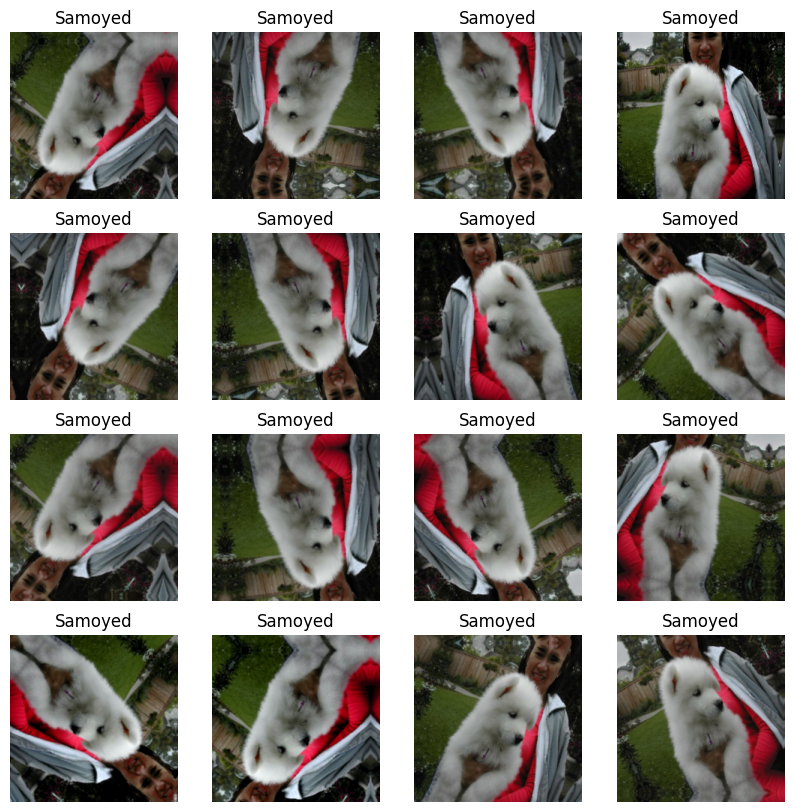

In [ ]:
# Аугментация на примере 1го изображения из 1го батча
plt.figure(figsize=(10, 10))
for images, label in train_ds.take(1):
    for i in range(16):
        augmented_images = img_augmentation(images[0])
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(keras.utils.img_to_array(augmented_images).astype("uint8"))
        plt.title("{}".format(CLASS_LIST[label[0]])) # Вывод метки
        plt.axis("off")

In [ ]:
# Применяем `img_augmentation` к обучающей выборке
train_ds = train_ds.map(
    lambda img, label: (img_augmentation(img), keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE,)

val_ds = val_ds.map(
    lambda img, label: (img, keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE,)

test_ds = test_ds.map(
    lambda img, label: (img, keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE,)

# Предварительная выборка примеров в память GPU или оперативную память
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)
test_ds = test_ds.prefetch(tf_data.AUTOTUNE)

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    model = EfficientNetV2B0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Заморозка предобученных весов
    model.trainable = False

    # Замена верхних слоев
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Компилируем
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )
    return model

In [ ]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = '{epoch:02d}-{val_acc:.2f}.keras',
                             monitor = 'val_acc',
                             save_best_only = True,
                             mode = 'max',
                             verbose = 0)
]

model = build_model(num_classes=CLASS_COUNT)

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

Epoch 1/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - acc: 0.3695 - loss: 3.4703 - val_acc: 0.7841 - val_loss: 0.8128
Epoch 2/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - acc: 0.5818 - loss: 1.8544 - val_acc: 0.8078 - val_loss: 0.6447
Epoch 3/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - acc: 0.6376 - loss: 1.3715 - val_acc: 0.8192 - val_loss: 0.5834
Epoch 4/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - acc: 0.6670 - loss: 1.1846 - val_acc: 0.8282 - val_loss: 0.5335
Epoch 5/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - acc: 0.6750 - loss: 1.1293 - val_acc: 0.8245 - val_loss: 0.5511
Epoch 6/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - acc: 0.6888 - loss: 1.0793 - val_acc: 0.8303 - val_loss: 0.5314
Epoch 7/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - acc: 0.6946 - loss: 1.0440 - val_acc: 0.8274 - val_loss: 0.5630
Epoch 8/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - acc: 0.6996 - loss: 1.0407 - val_acc: 0.8236 - val_loss: 0.5668
Epoch 9/20
97/97 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - acc: 0.7049

In [ ]:
# Функция отрисовки графиков
def show_plot(history):
    acc = history.history['acc']
    epochs = range(1, len(acc) + 1)
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, 'b', label='Точность на проверочной выборке')
    plt.title('График точности на обучающей и проверочной выборках')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, 'b', label='Потери на проверочной выборке')
    plt.title('График потерь на обучающей и проверочной выборках')
    plt.legend()
    plt.show()

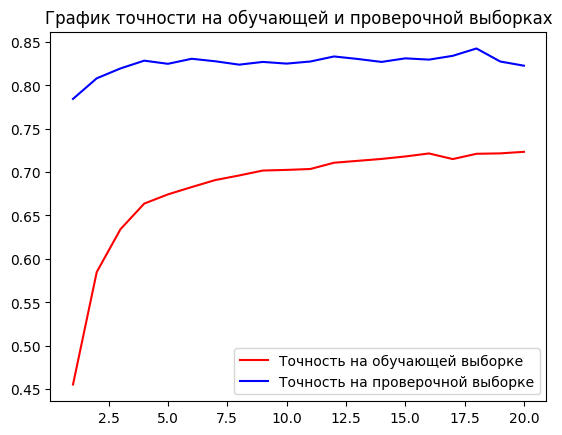

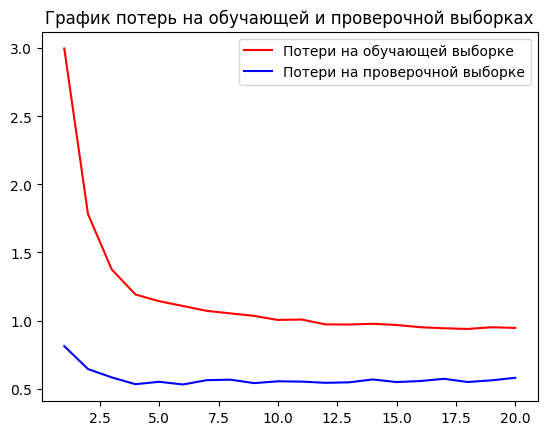

In [ ]:
show_plot(history)

In [ ]:
# Загрузим сохраненную модель
model = build_model(num_classes=CLASS_COUNT)
model = keras.saving.load_model('18-0.84.keras')

**Разморозка весов**

In [ ]:
def unfreeze_model(model):
    # Мы размораживаем 20 верхних слоев за исключением BatchNormalization
    for layer in model.layers[-25:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    # В оптимизаторе устанавливаем маленький шаг обучения
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )


unfreeze_model(model)

In [ ]:
epochs = 5

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = 'step2_{epoch:02d}-{val_acc:.2f}.keras',
                             monitor = 'val_acc',
                             save_best_only = True,
                             mode = 'max',
                             verbose = 0)
]

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

Epoch 1/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 398s 3s/step - acc: 0.7583 - loss: 0.8363 - val_acc: 0.8395 - val_loss: 0.5429
Epoch 2/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - acc: 0.7812 - loss: 0.7210 - val_acc: 0.8432 - val_loss: 0.5367
Epoch 3/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - acc: 0.7981 - loss: 0.6507 - val_acc: 0.8405 - val_loss: 0.5395
Epoch 4/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - acc: 0.8048 - loss: 0.6177 - val_acc: 0.8379 - val_loss: 0.5422
Epoch 5/5
97/97 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - acc: 0.8027 - loss: 0.6135 - val_acc: 0.8383 - val_loss: 0.5442


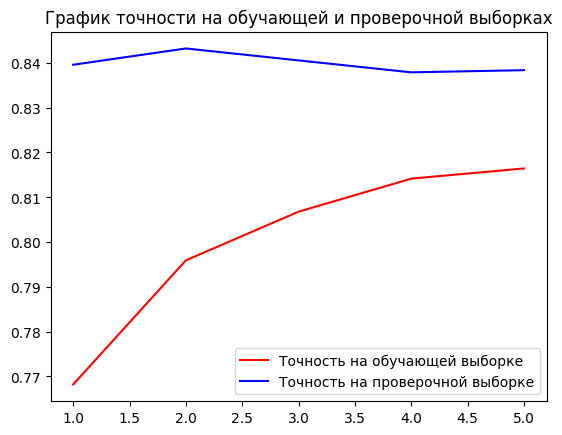

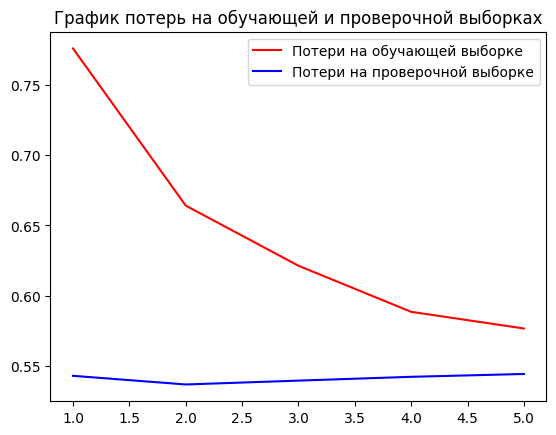

In [ ]:
show_plot(history)

***Подгонка модели с меньшей скоростью обучения и эффекта для проверочной точности не дает***

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print('Точность на контрольной выборке:', test_acc)

32/32 ━━━━━━━━━━━━━━━━━━━━ 32s 338ms/step - acc: 0.8334 - loss: 0.5850
Точность на контрольной выборке: 0.842529296875


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
tf.Tensor(46, shape=(), dtype=int32)


(-0.5, 223.5, 223.5, -0.5)

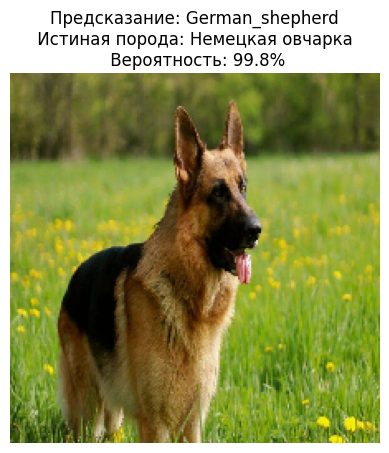

In [ ]:
TEST_IMG='./ovcharka.jpg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)

img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)
print(keras.ops.argmax(predictions))

plt.title("Предсказание: %s\n Истиная порода: Немецкая овчарка \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")

# **Случайным образом отобрать 10 пород собак**

In [ ]:
import random
import shutil

In [ ]:
CLASS_LIST2 = sorted(random.sample(os.listdir(IMAGE_PATH), k=10))
IMAGE_PATH2 = './dataset2/'

print("Случайно выбранные 10 классов:", CLASS_LIST2)

Случайно выбранные 10 классов: ['Appenzeller', 'Basset', 'Borzoi', 'Irish_water_spaniel', 'Kerry_blue_terrier', 'Kuvasz', 'Leonberg', 'Lhasa', 'Pug', 'Weimaraner']


In [ ]:
def create_dataset(img_path: str, new_path: str, class_name: str):
    if not os.path.exists(new_path):
        os.mkdir(new_path)

    src_path = os.path.join(img_path, class_name)  # Полный путь к папке с изображениями класса
    dst_path = os.path.join(new_path, class_name)  # Полный путь к папке с новым датасетом класса

    # Получение списка имен файлов с изображениями текущего класса
    class_files = os.listdir(src_path)
    # Создаем подпапку, используя путь
    if not os.path.exists(dst_path):
        os.mkdir(dst_path)

    for fname in class_files:
        src = os.path.join(src_path, fname)
        dst = os.path.join(dst_path, fname)
        shutil.copyfile(src, dst)

In [ ]:
# Скопируем 10 классов в новый датасет
for class_name in CLASS_LIST2:
    create_dataset(IMAGE_PATH, IMAGE_PATH2, class_name)

In [ ]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    IMAGE_PATH2,
    validation_split=0.2,
    subset="both",
    seed=20,
    shuffle=True,
    image_size=IMAGE_SIZE,
    batch_size=32,
)

Found 1712 files belonging to 10 classes.
Using 1370 files for training.
Using 342 files for validation.


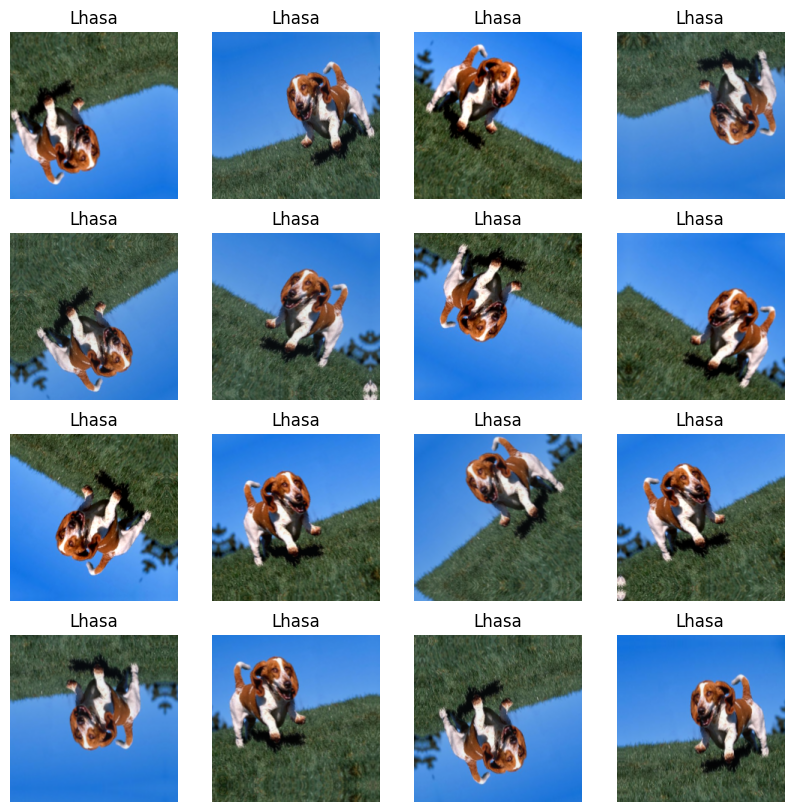

In [ ]:
# Аугментация на примере 2го изображения из 1го батча
plt.figure(figsize=(10, 10))
for images, label in train_ds.take(1):
    for i in range(16):
        augmented_images = img_augmentation(images[1])
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(keras.utils.img_to_array(augmented_images).astype("uint8"))
        plt.title("{}".format(CLASS_LIST2[label[0]])) # Вывод метки
        plt.axis("off")

In [ ]:
# Применяем `img_augmentation` к обучающей выборке
train_ds = train_ds.map(
    lambda img, label: (img_augmentation(img), keras.ops.one_hot(label, 10)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE,)

val_ds = val_ds.map(
    lambda img, label: (img, keras.ops.one_hot(label, 10)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE,)

# Предварительная выборка примеров в память GPU или оперативную память
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [ ]:
# Загрузим сохраненную модель
model = build_model(num_classes=10)

In [ ]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = 'step3_{epoch:02d}-{val_acc:.2f}.keras',
                             monitor = 'val_acc',
                             save_best_only = True,
                             mode = 'max',
                             verbose = 0)
]

model = build_model(num_classes=10)

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

Epoch 1/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - acc: 0.6898 - loss: 1.1386 - val_acc: 0.9912 - val_loss: 0.0411
Epoch 2/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 59s 447ms/step - acc: 0.8783 - loss: 0.6903 - val_acc: 0.9854 - val_loss: 0.0411
Epoch 3/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 440ms/step - acc: 0.8855 - loss: 0.6481 - val_acc: 0.9854 - val_loss: 0.0638
Epoch 4/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 506ms/step - acc: 0.9047 - loss: 0.5408 - val_acc: 0.9942 - val_loss: 0.0608
Epoch 5/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 23s 529ms/step - acc: 0.9286 - loss: 0.3807 - val_acc: 0.9942 - val_loss: 0.0439
Epoch 6/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 37s 423ms/step - acc: 0.9130 - loss: 0.5610 - val_acc: 0.9942 - val_loss: 0.0651
Epoch 7/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 429ms/step - acc: 0.9232 - loss: 0.4609 - val_acc: 0.9912 - val_loss: 0.0538
Epoch 8/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 19s 420ms/step - acc: 0.9198 - loss: 0.4927 - val_acc: 0.9883 - val_loss: 0.0674
Epoch 9/20
43/43 ━━━━━━━━━━━━━━━━━━━━ 20s 440ms/st

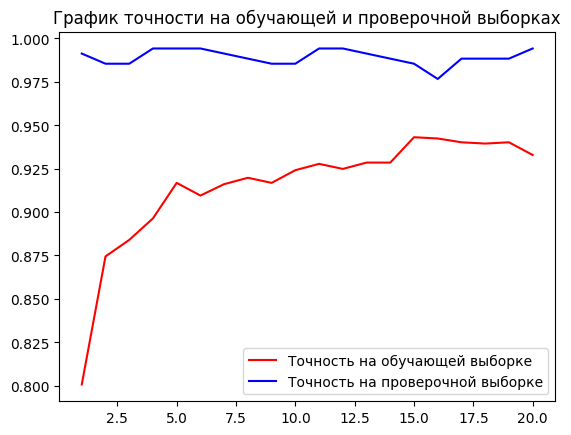

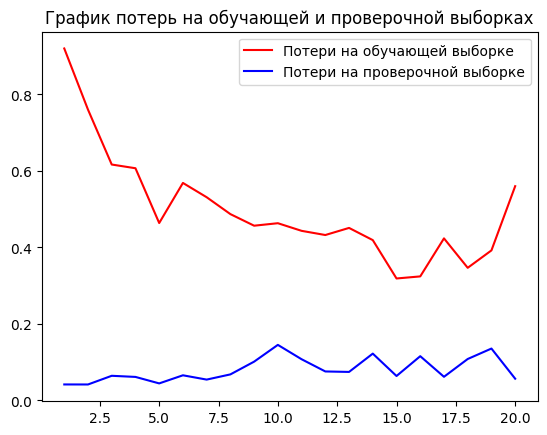

In [ ]:
show_plot(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
tf.Tensor(2, shape=(), dtype=int32)


(-0.5, 223.5, 223.5, -0.5)

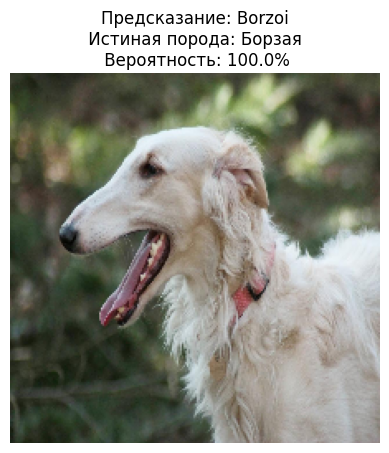

In [ ]:
TEST_IMG='./borzaya.jpg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)

img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)
print(keras.ops.argmax(predictions))

plt.title("Предсказание: %s\n Истиная порода: Борзая \n Вероятность: %2.1f%%" %
 (CLASS_LIST2[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")